In [1]:
import numpy as np
import tensorflow as tf
import os
import copy
from math import pi
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pandas import DataFrame as DF
from models import AP_ResNet, ResNet, VGG_branch, ResNetLSTM, ConvLSTM, ConvLSTM_dropout
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from classifier import preprocessing as prep
import os
import gc
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

2022-08-26 01:21:31.985109: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class_names = ['asphalt','bicycle','block','floor','ground']
bound = 414

In [3]:
label2idx_Dict = {
                'asphalt' : 0,
                'bicycle' : 1,
                'block' : 2,
                'floor' : 3,
                'ground' : 4,
            }

idx2label_Dict = {
    0 : 'asphalt',
    1 : 'bicycle',
    2 : 'block',
    3 : 'floor',
    4 : 'ground',
}

In [4]:
dir_path = './road_data'
def readNpy(dir_path):
    class_num = len(idx2label_Dict)

    Asphalt = list()
    Bicycle = list()
    Block = list()
    Floor = list()
    Ground = list()
    Asphalt = np.array(Asphalt)
    Bicycle = np.array(Bicycle)
    Block = np.array(Block)
    Floor = np.array(Floor)
    Ground = np.array(Ground)
    

    for dir in os.listdir(dir_path):
        d_path = os.path.join(dir_path, dir)
        file_list = os.listdir(d_path)
        for file in file_list:
            file_path = os.path.join(d_path, file)
            if dir == idx2label_Dict[0] :
                if len(Asphalt) == 0:
                    Asphalt = np.load(file_path, allow_pickle=True)
                else :
                    Asphalt = np.append(Asphalt, np.load(file_path), axis = 0)
            elif dir == idx2label_Dict[1]:
                if len(Bicycle) == 0:
                    Bicycle = np.load(file_path, allow_pickle=True)
                else :
                    Bicycle = np.append(Bicycle, np.load(file_path), axis = 0)
            elif dir == idx2label_Dict[2]:
                if len(Block) == 0:
                    Block = np.load(file_path, allow_pickle=True)
                else:
                    Block = np.append(Block, np.load(file_path), axis = 0)
            elif dir == idx2label_Dict[3]:
                if len(Floor) == 0:
                    Floor = np.load(file_path, allow_pickle=True)
                else:
                    Floor = np.append(Floor, np.load(file_path), axis = 0)
            elif dir == idx2label_Dict[4]:
                if len(Ground) == 0:
                    Ground = np.load(file_path, allow_pickle=True)
                else:
                    Ground = np.append(Ground, np.load(file_path), axis = 0)

    bound = Asphalt.shape[1]

    Ground_label = np.full((Ground.shape[0], class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['ground']])
    Asphalt_label = np.full((Asphalt.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['asphalt']])
    Bicycle_label = np.full((Bicycle.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['bicycle']])
    Block_label = np.full((Block.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['block']])
    Floor_label = np.full((Floor.shape[0],class_num), np.eye(len(label2idx_Dict))[label2idx_Dict['floor']])

    Ground = np.concatenate((Ground, Ground_label), axis=1)
    Asphalt = np.concatenate((Asphalt, Asphalt_label), axis=1)
    Bicycle = np.concatenate((Bicycle, Bicycle_label), axis=1)
    Block = np.concatenate((Block, Block_label), axis=1)
    Floor = np.concatenate((Floor, Floor_label), axis=1)
    
    array = Asphalt
    array = np.append(array, Bicycle, axis = 0)
    array = np.append(array, Block, axis = 0)
    array = np.append(array, Floor, axis = 0)
    array = np.append(array, Ground, axis = 0)
    s = np.arange(array.shape[0])
    np.random.shuffle(s)
    array_s = array[s]

    X = array_s[:,:bound]
    Y = np.real(array_s[:,bound:])
    return copy.deepcopy(X), copy.deepcopy(Y)

X, y = readNpy(dir_path)

In [5]:
def seperater(arr):
    global maximum
    pre_data = arr
    amp = np.abs(pre_data)
    amp = amp / maximum
    phs = np.angle(pre_data)
    # phs = (phs - (- pi)) / (pi - (- pi))
    sin = np.sin(phs)
    sin = (sin + 1) / 2
    seperated_data = np.stack((amp.T,sin.T), axis=0)
    seperated_data = np.expand_dims(seperated_data, axis=0)
    return np.array(seperated_data)

In [6]:
def dataSeperator(arr):
    temp = copy.deepcopy(seperater(arr[0]))
    for i in range(1, len(arr)):
        temp = np.concatenate((temp, seperater(arr[i])), axis=0)
    return temp

In [7]:
maximum = np.max(np.abs(X))
Split_X = dataSeperator(X)

In [8]:
checkpoint_filepath = 'CNN'
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = './model/' + checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only = True,
    save_weigths_only = False,
)
log_dir = './logs/fit/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1)

In [9]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data[0])-seq_length-1):
        x = data[0][:][i:(i+seq_length)]
        y = data[1][i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [10]:
seq_length = 50
X, Y = create_sequences((Split_X, y), seq_length = seq_length)

In [11]:
print(X.shape, Y.shape)

(2349, 50, 2, 414) (2349, 5)


In [12]:
def train(
    model, X, Y,
    test_X, test_Y, 
    batch_size = 64, history_dict = None,
    Epoch = 50,
    learning_rate = 1e-3
    ):
    callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = './model/' + 'Resnet_LSTM',
        monitor='val_accuracy',
        mode='max',
        save_best_only = True,
        save_weigths_only = False,
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    model.compile(optimizer = optimizer , loss = loss, 
                metrics = ['accuracy', 'categorical_crossentropy'])
    history = model.fit(X, Y,  batch_size = batch_size, epochs = Epoch,
                callbacks = callback, 
                validation_data = (test_X, test_Y),
                # validation_split = 0.3
                )
    return history

In [13]:
X = X[:, :, 0, :]

In [14]:
x_train, x_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [15]:
X_train = np.expand_dims(x_train, axis = -1)
X_test = np.expand_dims(x_test, axis = -1)

In [16]:
model_vgg = VGG16(
    include_top = True,
    weights = 'imagenet',
    classes = 5,
    classifier_activation = 'softmax',
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
)

ValueError: If using `weights` as `"imagenet"` with `include_top` as true, `classes` should be 1000.  Received `classes=5`

In [45]:
history = train(model_vgg, X_train, Y_train, X_test, Y_test)

NameError: name 'model_vgg' is not defined

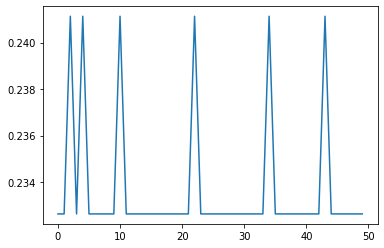

In [27]:
plt.plot(history.history['val_accuracy'])


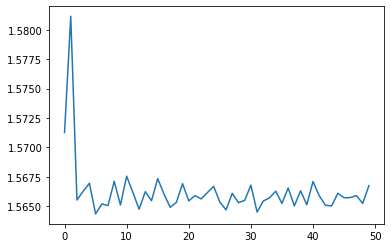

In [28]:
plt.plot(history.history['val_loss'])

In [31]:
del model_vgg
gc.collect()

1770008

In [34]:
model_resnet = tf.keras.applications.ResNet152V2(
    include_top = True,
    weights = None,
    classes = 5,
    classifier_activation = 'softmax',
    input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
)

In [35]:
resnet_history = train(model_resnet, X_train, Y_train, X_test, Y_test)

Epoch 1/50
26/26 [==============================] - ETA: 0s - loss: 1.7190 - accuracy: 0.2512 - categorical_crossentropy: 1.7190

INFO:tensorflow:Assets written to: ./model/Resnet_LSTM/assets


INFO:tensorflow:Assets written to: ./model/Resnet_LSTM/assets


26/26 [==============================] - 63s 2s/step - loss: 1.7190 - accuracy: 0.2512 - categorical_crossentropy: 1.7190 - val_loss: 1.6053 - val_accuracy: 0.2326 - val_categorical_crossentropy: 1.6053
Epoch 2/50
26/26 [==============================] - ETA: 0s - loss: 1.5846 - accuracy: 0.2457 - categorical_crossentropy: 1.5846

INFO:tensorflow:Assets written to: ./model/Resnet_LSTM/assets


INFO:tensorflow:Assets written to: ./model/Resnet_LSTM/assets


26/26 [==============================] - 47s 2s/step - loss: 1.5846 - accuracy: 0.2457 - categorical_crossentropy: 1.5846 - val_loss: 1.5803 - val_accuracy: 0.2411 - val_categorical_crossentropy: 1.5803
Epoch 3/50
26/26 [==============================] - 6s 232ms/step - loss: 1.6060 - accuracy: 0.2670 - categorical_crossentropy: 1.6060 - val_loss: 1.6238 - val_accuracy: 0.2411 - val_categorical_crossentropy: 1.6238
Epoch 4/50
26/26 [==============================] - 6s 228ms/step - loss: 1.5859 - accuracy: 0.2682 - categorical_crossentropy: 1.5859 - val_loss: 1.6168 - val_accuracy: 0.2411 - val_categorical_crossentropy: 1.6168
Epoch 5/50
26/26 [==============================] - ETA: 0s - loss: 1.5720 - accuracy: 0.2938 - categorical_crossentropy: 1.5720

INFO:tensorflow:Assets written to: ./model/Resnet_LSTM/assets


INFO:tensorflow:Assets written to: ./model/Resnet_LSTM/assets


26/26 [==============================] - 48s 2s/step - loss: 1.5720 - accuracy: 0.2938 - categorical_crossentropy: 1.5720 - val_loss: 1.6939 - val_accuracy: 0.2709 - val_categorical_crossentropy: 1.6939
Epoch 6/50
26/26 [==============================] - 6s 231ms/step - loss: 1.5300 - accuracy: 0.3321 - categorical_crossentropy: 1.5300 - val_loss: 1.9363 - val_accuracy: 0.2411 - val_categorical_crossentropy: 1.9363
Epoch 7/50
26/26 [==============================] - 6s 230ms/step - loss: 1.4621 - accuracy: 0.3954 - categorical_crossentropy: 1.4621 - val_loss: 2.0444 - val_accuracy: 0.2709 - val_categorical_crossentropy: 2.0444
Epoch 8/50
26/26 [==============================] - 6s 230ms/step - loss: 1.4530 - accuracy: 0.4173 - categorical_crossentropy: 1.4530 - val_loss: 1.6535 - val_accuracy: 0.2553 - val_categorical_crossentropy: 1.6535
Epoch 9/50
26/26 [==============================] - 6s 229ms/step - loss: 1.3860 - accuracy: 0.4550 - categorical_crossentropy: 1.3860 - val_loss: 2.

INFO:tensorflow:Assets written to: ./model/Resnet_LSTM/assets


INFO:tensorflow:Assets written to: ./model/Resnet_LSTM/assets


26/26 [==============================] - 49s 2s/step - loss: 0.6052 - accuracy: 0.7725 - categorical_crossentropy: 0.6052 - val_loss: 5.1998 - val_accuracy: 0.2752 - val_categorical_crossentropy: 5.1998
Epoch 19/50
26/26 [==============================] - 6s 230ms/step - loss: 0.5308 - accuracy: 0.7987 - categorical_crossentropy: 0.5308 - val_loss: 6.6638 - val_accuracy: 0.2681 - val_categorical_crossentropy: 6.6638
Epoch 20/50
26/26 [==============================] - 6s 230ms/step - loss: 0.4495 - accuracy: 0.8248 - categorical_crossentropy: 0.4495 - val_loss: 4.3235 - val_accuracy: 0.2227 - val_categorical_crossentropy: 4.3235
Epoch 21/50
26/26 [==============================] - 6s 230ms/step - loss: 0.4025 - accuracy: 0.8528 - categorical_crossentropy: 0.4025 - val_loss: 4.1139 - val_accuracy: 0.2340 - val_categorical_crossentropy: 4.1139
Epoch 22/50
26/26 [==============================] - 6s 227ms/step - loss: 0.3667 - accuracy: 0.8704 - categorical_crossentropy: 0.3667 - val_loss

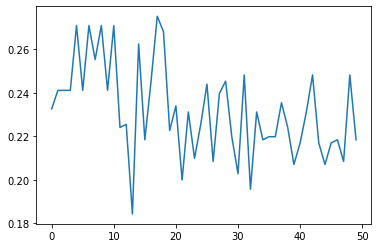

In [40]:
plt.plot(resnet_history.history['val_accuracy'])

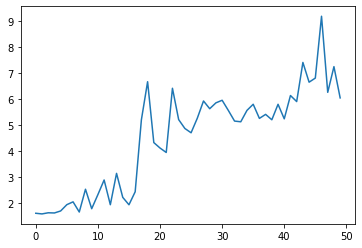

In [41]:
plt.plot(resnet_history.history['val_loss'])

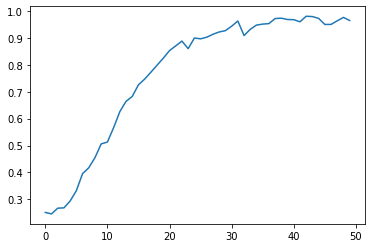

In [42]:
plt.plot(resnet_history.history['accuracy'])

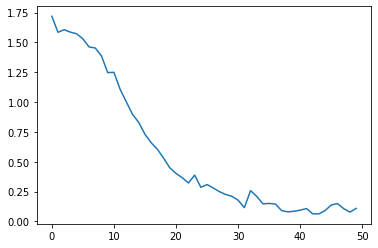

In [43]:
plt.plot(resnet_history.history['loss'])